# ADSP 32014 Bayesian Machine Learning with Generative AI

# Real vs AI-generated Image Classification

## Team <b>Optimus Primes</b>: Ultra, Pang, Monica, Ankit

## Required Packages

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from transformers import AutoFeatureExtractor, AutoModel
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn.functional as F

## Load and Preprocess Data

In [4]:
transform = transforms.Compose([
    transforms.Resize((128, 128)), # Reduced resolution for lower computational cost
    transforms.ToTensor(),
])

dataset_path = '/Users/ankitagrawal/Downloads/dataset'
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

print("Classes:", dataset.classes)

Classes: ['ai', 'real']


## Load Pre-Trained Vision Transformer (ViT) and Extract Features

In [5]:
dino_model_name = "facebook/dino-vits16"
feature_extractor = AutoFeatureExtractor.from_pretrained(dino_model_name)
dino_model = AutoModel.from_pretrained(dino_model_name)
dino_model.eval()  # Set to evaluation mode to reduce memory consumption

def extract_features(images):
    with torch.no_grad():
        inputs = feature_extractor(images, return_tensors="pt")
        outputs = dino_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)  # Global average pooling


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Train-Test Split and DataLoader Creation

In [6]:
from torch.utils.data import random_split, DataLoader

# Define train-test split ratio
train_size = int(0.8 * len(dataset))  # 80% Train, 20% Test
test_size = len(dataset) - train_size

# Split dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"Train Size: {len(train_dataset)} | Test Size: {len(test_dataset)}")

Train Size: 7704 | Test Size: 1926


## Bayesian Neural Network for Classification

In [ ]:
class BayesianSimpleCNN(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(BayesianSimpleCNN, self).__init__()

        # Fully Connected Layers
        self.fc1 = nn.Linear(384, 128)  
        self.dropout1 = nn.Dropout(dropout_rate)  # Monte Carlo Dropout
        self.relu = nn.ReLU()
        
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(64, num_classes)  # Final classification layer

    def forward(self, x):
        x = self.dropout1(x)  # Apply dropout before first FC layer
        x = self.fc1(x)
        x = self.relu(x)
        
        x = self.dropout2(x)  # Apply dropout before second FC layer
        x = self.fc2(x)
        x = self.fc3(x)  # Final output layer
        return x
      
num_classes = len(dataset.classes)
classifier = BayesianSimpleCNN(num_classes, dropout_rate=0.3)

## Model Training

In [67]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

def train_model():
    classifier.train()
    for epoch in range(10):  # 10 epochs
        running_loss = 0.0

        for images, labels in train_loader:
            features = extract_features(images)  # Get DINOv2 features
            optimizer.zero_grad()
            outputs = classifier(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

train_model()


Epoch 1, Loss: 0.6825
Epoch 2, Loss: 0.6206
Epoch 3, Loss: 0.5786
Epoch 4, Loss: 0.5352
Epoch 5, Loss: 0.5251
Epoch 6, Loss: 0.4918
Epoch 7, Loss: 0.4799
Epoch 8, Loss: 0.4765
Epoch 9, Loss: 0.4518
Epoch 10, Loss: 0.4700


## Save Model

In [ ]:
torch.save({
    'model_state_dict': classifier.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, "classifier_92accuracy.pth")

## Model Evaluation

In [68]:
def evaluate_model():
    classifier.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            features = extract_features(images)
            outputs = classifier(features)

            _, predicted = torch.max(outputs, 1)  # Get class with highest probability
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

evaluate_model()

Test Accuracy: 91.69%


## Feature Importance Analysis Using Gradients

In [69]:
def compute_feature_importance(model, feature_vector):
    """
    Compute feature importance using gradients.
    """
    model.train()  # Set model to train mode (required for dropout and gradient computation)
    feature_vector = feature_vector.clone().requires_grad_(True)  # Enable gradient computation for the input

    # Forward pass
    output = model(feature_vector)
    predicted_class = torch.argmax(output, dim=1)  # Get the predicted class

    # Backward pass for the predicted class
    output[:, predicted_class].sum().backward()  # Sum to create a scalar for backward pass

    # Compute feature importance as the absolute gradient values
    feature_importance = torch.abs(feature_vector.grad).mean(dim=0).cpu().numpy()
    return feature_importance

## Visualizing Feature Importance on the Image

In [70]:
def visualize_feature_importance(image, feature_importance, patch_size=16):
    """
    Visualizes the feature importance on the input image by mapping it to patches.
    
    Args:
        image (np.ndarray or torch.Tensor): The input image with shape (1, C, H, W) or (C, H, W).
        feature_importance (np.ndarray): Importance scores for each feature (vector).
        patch_size (int): Size of each patch in pixels.
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle
    import numpy as np

    # Convert image to numpy array if it's a torch tensor
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()

    # Remove batch dimension if present
    if image.ndim == 4:  # Shape: (1, C, H, W)
        image = image.squeeze(0)  # Remove batch dimension -> (C, H, W)

    # Transpose image to (H, W, C) if necessary
    if image.shape[0] == 3:  # Shape: (C, H, W)
        image = np.transpose(image, (1, 2, 0))  # Transpose to (H, W, C)

    # Get image dimensions
    if len(image.shape) == 2:  # Grayscale image (H, W)
        H, W = image.shape
        C = 1  # Single channel
    elif len(image.shape) == 3:  # RGB image (H, W, C)
        H, W, C = image.shape
    else:
        raise ValueError(f"Unsupported image shape: {image.shape}")

    # Calculate the number of patches along height and width
    H_patches = H // patch_size
    W_patches = W // patch_size

    # Check if the feature importance size matches the patch grid
    if feature_importance.size != H_patches * W_patches:
        print(f"Feature importance size {feature_importance.size} does not match patch grid {H_patches}x{W_patches}.")
        print("Reshaping feature importance to match the patch grid.")
        # Reshape feature_importance to the nearest square dimensions
        size = int(np.sqrt(feature_importance.size))
        feature_importance = feature_importance[:size * size].reshape(size, size)
        H_patches, W_patches = size, size  # Update patch grid dimensions

    # Create a figure to display the image
    plt.figure(figsize=(10, 5))
    if C == 1:  # Grayscale image
        plt.imshow(image, cmap='gray')
    else:  # RGB image
        plt.imshow(image)

    # Overlay patches with feature importance
    for i in range(H_patches):
        for j in range(W_patches):
            importance = feature_importance[i, j]
            # Clip alpha to the range [0, 1]
            alpha = np.clip(importance, 0, 1)
            # Draw a rectangle for each patch
            rect = Rectangle(
                (j * patch_size, i * patch_size),  # (x, y) of the patch
                patch_size, patch_size,  # Width and height of the patch
                linewidth=1, edgecolor='r', facecolor='yellow', alpha=alpha
            )
            plt.gca().add_patch(rect)

    plt.colorbar(label='Feature Importance')
    plt.title('Feature Importance Visualization (Patches)')
    plt.axis('off')
    plt.show()


## Bayesian Inference for Uncertainty Estimation

In [71]:
def bayesian_inference(model, feature_vector, num_samples=200):
    model.train()  # Keep dropout active for Bayesian inference
    device = next(model.parameters()).device
    feature_vector = feature_vector.to(device)

    preds = []
    feature_importances = []

    # Monte Carlo sampling (without gradient tracking)
    with torch.no_grad():  # Disable gradient tracking for MC sampling
        for i in range(num_samples):
            # Forward pass
            output = model(feature_vector)
            probs = torch.nn.functional.softmax(output, dim=1)
            preds.append(probs.cpu())

    # Compute feature importance
    feature_importance = compute_feature_importance(model, feature_vector)

    # Aggregate predictions
    preds = torch.stack(preds)
    mean_pred = preds.mean(dim=0).numpy()
    uncertainty = preds.std(dim=0).numpy()

    return mean_pred, uncertainty, feature_importance

## Classifying real-world images

In [72]:
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image


In [73]:
def predict_image(image_path, uncertainty_threshold_multiplier=1.0, top_n=10, patch_size=16):
    # Preprocess Image & Extract Features
    image = preprocess_image(image_path)  # Ensure this returns a tensor with shape (1, C, H, W)
    features = extract_features(image)

    # Predict Class (Standard Inference)
    classifier.eval()
    with torch.no_grad():
        output = classifier(features)
        probabilities = torch.nn.functional.softmax(output, dim=1).squeeze().cpu().numpy()
    
    class_idx = np.argmax(probabilities)  # Get predicted class (AI or Real)
    confidence = probabilities[class_idx]  # Get confidence score

    print(f"Predicted Class: {dataset.classes[class_idx]}")
    print(f"Confidence: {confidence:.4f}")

    # Run Bayesian Inference (MC Dropout)
    mean_pred, uncertainty, feature_importance = bayesian_inference(classifier, features)

    # Compute Uncertainty for Predicted Class
    uncertainty = uncertainty.squeeze()  # Ensure uncertainty is 1D

    # Handle unexpected uncertainty shape
    if uncertainty.ndim > 1 or len(uncertainty) <= class_idx:
        print("Unexpected Uncertainty Shape, Defaulting to Mean Uncertainty")
        uncertainty_score = float(np.mean(uncertainty))  # Default to mean if incorrect shape
    else:
        uncertainty_score = float(uncertainty[class_idx])  # Extract as a scalar

    print(f"Bayesian Uncertainty: {uncertainty_score:.4f}")

    # Visualize Feature Importance
    visualize_feature_importance(image, feature_importance, patch_size=patch_size)  # Visualize important patches

    return dataset.classes[class_idx], confidence, uncertainty_score, feature_importance

In [74]:
print(classifier)

BayesianSimpleCNN(
  (fc1): Linear(in_features=384, out_features=128, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)


Predicted Class: ai
Confidence: 0.5973
Bayesian Uncertainty: 0.1268
Feature importance size 384 does not match patch grid 8x8.
Reshaping feature importance to match the patch grid.


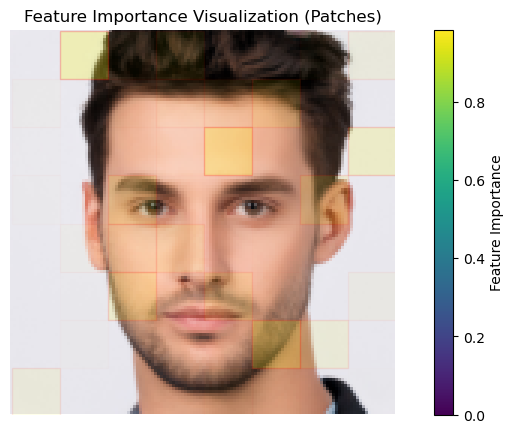

('ai',
 0.5973453,
 0.12679260969161987,
 array([0.00000000e+00, 2.29527041e-01, 2.68220771e-02, 6.26994222e-02,
        0.00000000e+00, 0.00000000e+00, 1.81990098e-02, 6.96665943e-02,
        1.01263914e-03, 0.00000000e+00, 6.19406346e-03, 3.34599838e-02,
        0.00000000e+00, 4.34612393e-01, 1.76561907e-01, 1.91958323e-02,
        2.35229179e-01, 5.46372756e-02, 8.07369724e-02, 1.97272841e-02,
        0.00000000e+00, 1.16678020e-02, 3.25839184e-02, 3.89729440e-02,
        8.68791491e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 6.69660866e-02, 1.39938958e-03,
        0.00000000e+00, 7.13536441e-02, 0.00000000e+00, 0.00000000e+00,
        1.30980008e-03, 1.39472599e-03, 9.24670976e-03, 0.00000000e+00,
        3.49078397e-03, 1.59343164e-02, 2.19423905e-01, 1.82423380e-03,
        7.32245948e-03, 1.55863166e-01, 7.26722274e-03, 0.00000000e+00,
        0.00000000e+00, 4.30905879e-01, 0.00000000e+00, 8.43480695e-03,
        3.75366300e-01,

In [83]:
image_path = '/Users/ankitagrawal/Desktop/100k-ai-faces-6.jpg'
predict_image(image_path)

## Occlusion Sensitivity

In [76]:
def occlusion_sensitivity(image, model, patch_size=16, stride=8):
    image_np = image.squeeze().permute(1, 2, 0).cpu().numpy()  # Convert to numpy
    h, w, _ = image_np.shape

    # Initialize the sensitivity map
    sensitivity_map = np.zeros((h, w))

    # Loop through the image with sliding window
    for i in range(0, h - patch_size, stride):
        for j in range(0, w - patch_size, stride):
            # Create an occluded copy of the image
            occluded_image = image.clone()
            occluded_image[:, :, i:i+patch_size, j:j+patch_size] = 0  # Occlude the patch

            # Extract features from occluded image
            occluded_features = extract_features(occluded_image)

            # Perform inference
            with torch.no_grad():
                output = model(occluded_features)
                prob = torch.nn.functional.softmax(output, dim=1).cpu().numpy()

            # Calculate the sensitivity score for the current patch
            sensitivity_map[i:i+patch_size, j:j+patch_size] = prob[0, 1]  # Sensitivity score for class 1 (AI-Generated)

    return sensitivity_map

In [77]:
def predict_image_occlusion(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension

    features = extract_features(image)  # Extract features from DINO
    classifier.eval()

    # Predict Class
    with torch.no_grad():
        output = classifier(features)
        probabilities = torch.nn.functional.softmax(output, dim=1).squeeze().cpu().numpy()

    class_idx = np.argmax(probabilities)  # Get predicted class (AI or Real)
    confidence = probabilities[class_idx]  # Get confidence score

    print(f"Predicted Class: {dataset.classes[class_idx]}")
    print(f"Confidence: {confidence:.4f}")

    # Bayesian Inference
    mean_pred, uncertainty,feature_importance = bayesian_inference(classifier, features)

    # Occlusion Sensitivity Map
    sensitivity_map = occlusion_sensitivity(image, classifier)

    # Visualize Occlusion Sensitivity Map
    plt.figure(figsize=(8, 8))
    plt.imshow(image.squeeze().permute(1, 2, 0).cpu().numpy())  # Show original image
    plt.imshow(sensitivity_map, cmap='hot', alpha=0.5, interpolation='nearest')  # Overlay sensitivity map
    plt.colorbar(label='Sensitivity Score')
    plt.title(f"Occlusion Sensitivity Map for {dataset.classes[class_idx]}")
    plt.show()

    # Get the uncertainty for the predicted class
    if len(uncertainty) > class_idx:
        uncertainty_score = uncertainty[class_idx]
    else:
        uncertainty_score = np.mean(uncertainty)  # Fallback to mean uncertainty

    print(f"Bayesian Uncertainty: {np.mean(uncertainty_score):.4f}")

Predicted Class: ai
Confidence: 0.5973


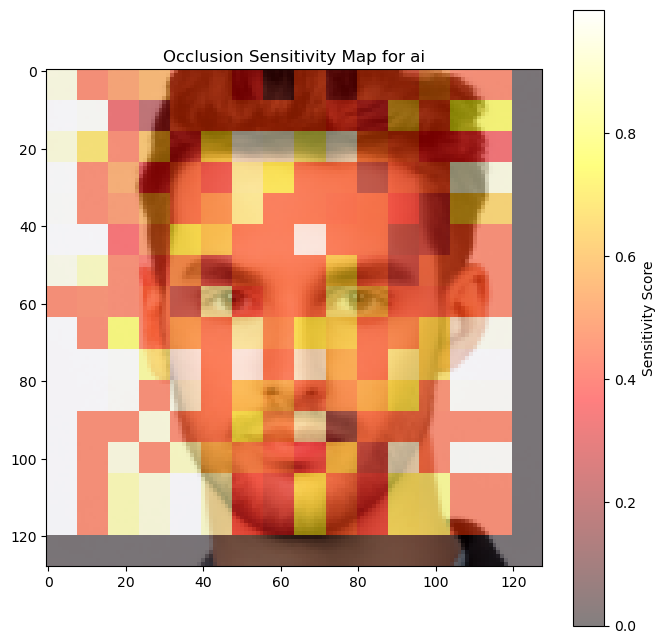

Bayesian Uncertainty: 0.1282


In [84]:
image_path = '/Users/ankitagrawal/Desktop/100k-ai-faces-6.jpg'
predict_image_occlusion(image_path)